In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [2]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [3]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [4]:
config.read('scales_h2rg.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

## Read in Keck pupil

In [5]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

In [6]:
screen1 = np.zeros(pupil.pupil.shape)

In [7]:
###Set up a target spectrum to use with the SCALES PSF
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 10.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)
print(wav)
print(I_lam)

####set this up as a Target
targ = Target(wav,I_lam)

[0.05     0.05001  0.05002  ... 5.499925 5.49995  5.499975]
[1.2782356e-15 1.2860823e-15 1.2958241e-15 ... 1.2565724e-08 1.2565280e-08
 1.2564963e-08]


2.9_4.15_prism.txt


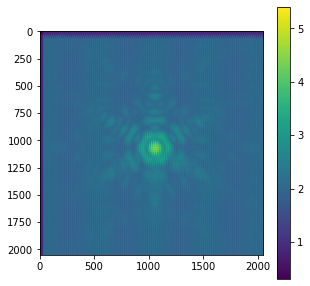

0.007699048519134522
2.0_5.2_prism.txt


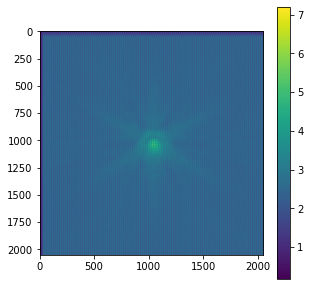

0.008920729160308838
2.0_4.0_prism.txt


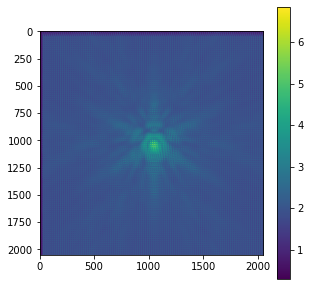

0.008278429508209229
3.1_3.5_prism.txt


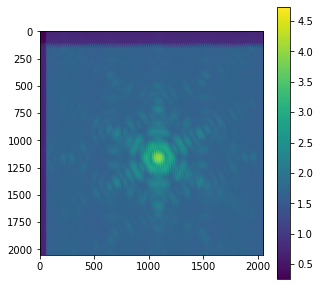

0.007767697175343831
4.5_5.2_prism.txt


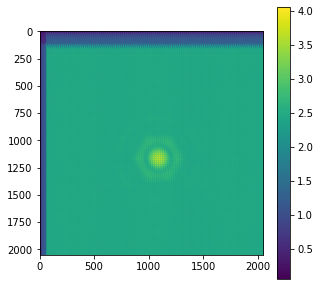

0.007484579086303711
1.95_2.45_prism.txt


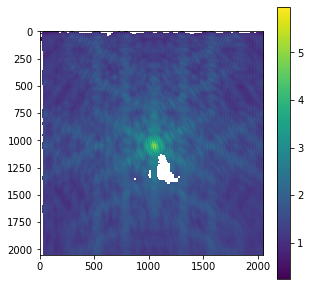

0.008279196421305339


In [12]:
modes = [[2.9,4.15],[2.0,5.2],[2.0,4.0],[3.1,3.5],[4.5,5.2],[1.95,2.45]]
for wavs in modes:
    wav_min,wav_max = wavs
    arg_spaxel['min_wavelength'] = wav_min #minimum wavelength in microns
    arg_spaxel['max_wavelength'] = wav_max #maximum wavelength in microns
    
    lens = Lenslet(arg_spaxel)
    lens.get_shifts()
    lens.make_trace(phys=True,disp=True,verbose=True)
    
    nspax = arg_spaxel['no_spaxel']
    nlam = lens.trace.shape[0]

    keck_cube = np.zeros((nlam, nspax, nspax))
    mag1 = magn(lens.lmin)
    mag2 = magn(lens.lmax)

    psf_file = 'keck_psf_cube_'+str(lens.lmin)+'_'+str(lens.lmax)+'_n'+str(nlam)+'.fits'
    if os.path.isfile(psf_file)==False:
        for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
            W = DFT_matrix(1600, mag)
            A = pupil.pupil * np.exp(1.j * screen1)
            out = abs(W.dot(A).dot(W))**2
            out /= np.sum(out, axis=(0,1))
            keck_cube[i] = frebin(out, (108, 108))
        fits.writeto(psf_file,np.array(keck_cube),clobber=True)
    else: keck_cube = pyfits.getdata(psf_file)

    vapor = 1 #PWV in mm
    airmass = 1 
    skybg = SkyBG(vapor,airmass)
    skytrans = SkyTrans(vapor,airmass)
    atmodisp = AtmoDispersion(90,20,600)

    telAO_emissivities = [0.4]
    telAO_temps = [285*u.K]
    scales_trans = [0.616]
    inst = InstTransEm(telAO_emissivities, telAO_temps, scales_trans)
    qe = QE(0.88) ##detector 6 is ~0.8, detector 8 is 0.88 -- testing "worst case" for saturation using detector 8
    
    
    filt = Filter(lmin=lens.lmin,lmax=lens.lmax,fkw='asahi')
    dit = 1 ###integration time in seconds
    
    ####organize all these and pass to focal_plane 
    args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
    fp = FocalPlane(args_new)
    
    from time import time
    t1 = time()
    rawfile_e = 'Astar_10pc_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_e_s.fits'
    if os.path.isfile(rawfile_e)==False:
        raw, bg_star_truth = fp.get_fp(dit*u.s,targ,return_full=True,PSF=keck_cube,return_phots=True)
        rawfile = 'Astar_10pc_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_phot_s.fits'
        pyfits.writeto(rawfile,np.array(raw),clobber=True)
        rawfile_e = 'Astar_10pc_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_e_s.fits'
        pyfits.writeto(rawfile_e,np.array(raw*0.88),clobber=True)
    else:
        raw = pyfits.getdata(rawfile_e)

    f = plt.figure(figsize=(5,5))
    plt.imshow(raw**0.1)
    plt.colorbar()
    plt.show()
    t2 = time()
    print((t2-t1)/60.0)

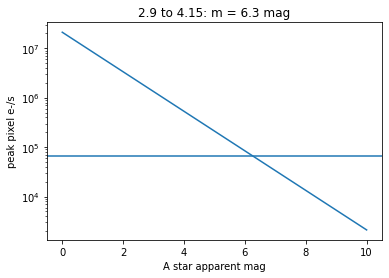

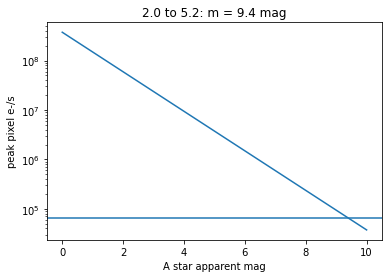

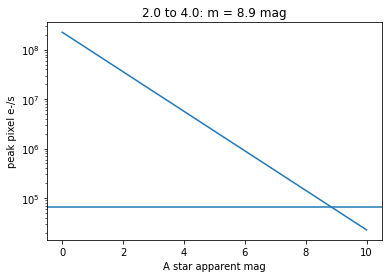

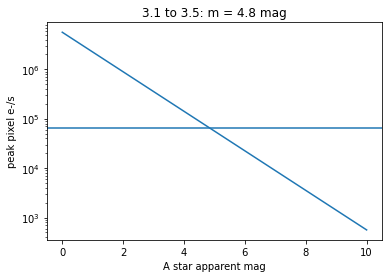

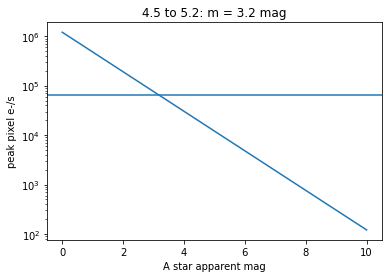

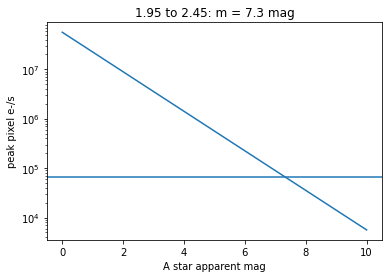

In [21]:
modes = [[2.9,4.15],[2.0,5.2],[2.0,4.0],[3.1,3.5],[4.5,5.2],[1.95,2.45]]
for wavs in modes:
    wav_min,wav_max = wavs 
    rawfile = 'Astar_10pc_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_e_s.fits'
    im = pyfits.getdata(rawfile)
    
    mpixs = []
    f = plt.figure()
    amags = np.linspace(0.0,10.0,101)
    for amag in amags:
        im2 = im * 10**(-amag/2.5)
        mpix = np.max(im2)
        mpixs.append(mpix)
    mpixs = np.array(mpixs)
    mlimit = amags[np.where(np.abs(mpixs-65000.0)==np.min(np.abs(mpixs-65000.)))][0]
    plt.title(str(wav_min)+' to '+str(wav_max)+': m = '+str(np.round(mlimit,2))+' mag')
    plt.plot(amags,mpixs)
    plt.xlabel('A star apparent mag')
    plt.ylabel('peak pixel e-/s')
    plt.yscale('log')
    plt.axhline(65000)
    plt.savefig('Astar_maglimit_'+str(wav_min)+'_'+str(wav_max)+'.png')
    plt.show()
